In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
%matplotlib inline

In [2]:
rawData = pd.read_csv('ED_COVID19_dashboard.csv')

In [3]:
# identify covid cases
rawData.loc[(rawData.ED_LAB_COVID19=="Positive") | (rawData.ED_LAB_COVID19=="Presumptive Positive"), 'ED_LAB_COVID19']  ="Detected"   
rawData.loc[(rawData.ED_LAB_COVID19=="Not Detected"), 'ED_LAB_COVID19'] ="Not detected"  
rawData = rawData.loc[(rawData.ED_LAB_COVID19 == 'Detected') | (rawData.ED_LAB_COVID19 == 'Not detected')]
rawData['covid'] = rawData.ED_LAB_COVID19=="Detected"

In [4]:
# clean outcomes
rawData.loc[(rawData.ED_PM_EXPIRED_IN_ED_YN=="Y"), 'ED_ADMIT_TO_ICU_YN'] = 1
rawData['icu'] = rawData.ED_ADMIT_TO_ICU_YN=="Y"


In [5]:
rawData.ED_LAB_COVID19.value_counts()

Not detected    738
Detected        301
Name: ED_LAB_COVID19, dtype: int64

In [6]:
pd.crosstab(rawData.covid, rawData.icu, dropna=False )

icu,False,True
covid,,
False,655,83
True,260,41


In [7]:
# truncate high low lab values and convert to floats
rawData.ED_LAB_CRP.replace('<0.2', 0.1, inplace=True)

rawData.ED_LAB_DDIMER.replace('<0.17', 0.085, inplace=True)
rawData.ED_LAB_DDIMER.replace('>35.00', 40, inplace=True)

rawData.ED_LAB_FERRITIN.replace('>16500.0', 17000, inplace=True)
rawData.ED_LAB_FERRITIN.replace('>1650.0', 17000, inplace=True)

rawData.ED_LAB_IL6.replace('>3670.0', 4100, inplace=True)
rawData.ED_LAB_IL6.replace('>4060.0', 4100, inplace=True)

rawData.ED_LAB_CMP_ALT.replace('<8', 4, inplace=True)

rawData.ED_LAB_HSTROP0.replace('<6', 3, inplace=True)
rawData.ED_LAB_HSTROP2.replace('<6', 3, inplace=True)

rawData.ED_LAB_CBC_PLT.replace('<2', 1, inplace=True)
rawData.ED_LAB_CMP_CR.replace('SEE BELOW', np.nan, inplace=True)
rawData.ED_LAB_CMP_CR.replace('<0.10', 0.005, inplace=True)


rawData.ED_LAB_CRP = rawData.ED_LAB_CRP.astype('float')
rawData.ED_LAB_DDIMER = rawData.ED_LAB_DDIMER.astype('float')
rawData.ED_LAB_FERRITIN = rawData.ED_LAB_FERRITIN.astype('float')
rawData.ED_LAB_IL6 = rawData.ED_LAB_IL6.astype('float')
rawData.ED_LAB_CMP_ALT = rawData.ED_LAB_CMP_ALT.astype('float')
rawData.ED_LAB_HSTROP0 = rawData.ED_LAB_HSTROP0.astype('float')
rawData.ED_LAB_HSTROP2 = rawData.ED_LAB_HSTROP2.astype('float')
rawData.ED_LAB_CBC_PLT = rawData.ED_LAB_CBC_PLT.astype('float')
rawData.ED_LAB_CMP_CR = rawData.ED_LAB_CMP_CR.astype('float')


In [8]:
rawData.ED_LAB_CBC_LYM

36      16.1
38      26.2
41      10.2
51      16.1
61       3.5
        ... 
1538    21.6
1540     NaN
1541     NaN
1542    13.9
1543    21.6
Name: ED_LAB_CBC_LYM, Length: 1039, dtype: float64

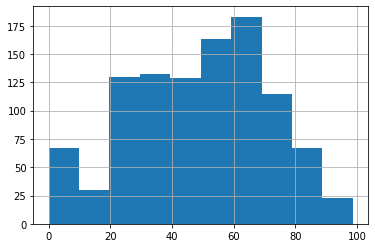

In [9]:
rawData.AGE_AT_VISIT_YRS.hist()


In [10]:
rawData.GENDER.value_counts()
rawData['female'] = rawData.GENDER=="F"

In [11]:
rawData['highFi02'] = rawData.TRIAGE_FIO2 > 50

In [12]:
rawData = rawData[['AGE_AT_VISIT_YRS', 'female', 'TRIAGE_SBP', 'TRIAGE_DBP', 'TRIAGE_HR', 'TRIAGE_TEMP',
                   'highFi02', 'ED_LAB_CRP', 'ED_LAB_DDIMER', 'ED_LAB_FERRITIN', 'ED_LAB_CBC_PLT', 'ED_LAB_CBC_LYM',
                   'ED_LAB_CMP_CR', 'ED_LAB_CMP_TBILI', 'ED_LAB_HSTROP0', 'ED_LAB_IL6', 'covid', 'icu']]

In [13]:
# impute missing lab and vitals values

import statsmodels.imputation.mice as mice

def ols_formula(df, dependent_var):
    df_columns = list(df.columns.values)
    df_columns.remove(dependent_var)
    fml = ''
    for col in df_columns:
        fml = fml + ' + ' + col
    return fml

imputedData = mice.MICEData(rawData)

for var in ['AGE_AT_VISIT_YRS', 'female', 'TRIAGE_SBP', 'TRIAGE_DBP', 'ED_LAB_CRP', 'ED_LAB_DDIMER', 
            'ED_LAB_FERRITIN', 'ED_LAB_CBC_PLT', 'ED_LAB_CMP_CR', 'ED_LAB_CMP_TBILI', 'ED_LAB_HSTROP0', 
            'ED_LAB_IL6', 'ED_LAB_CBC_LYM']:
    imputedData.set_imputer(var, formula=ols_formula(rawData, var))

imputedData.update_all(20)

In [14]:
cleanedData = imputedData.data

In [15]:
cleanedData.rename(columns={'AGE_AT_VISIT_YRS' : 'age', 'TRIAGE_SBP' : 'sbp', 'TRIAGE_DBP' : 'dbp',
                            'TRIAGE_HR' : 'hr', 'TRIAGE_TEMP' : 'temp', 'ED_LAB_CRP' : 'crp', 
                            'ED_LAB_DDIMER' : 'dDimer', 'ED_LAB_FERRITIN' : 'ferritin',
                            'ED_LAB_CBC_PLT' : 'platelets', 'ED_LAB_CMP_CR' : 'creatinine',  
                            'ED_LAB_CMP_TBILI' : 'tbili', 'ED_LAB_HSTROP0' : 'hsTrop', 
                            'ED_LAB_IL6' : 'il6', 'ED_LAB_CBC_LYM' : 'lymph'}, inplace=True)

In [16]:
cleanedData

,age,female,sbp,dbp,hr,temp,highFi02,crp,dDimer,ferritin,platelets,lymph,creatinine,tbili,hsTrop,il6,covid,icu
0,60.275,False,96.0,59.0,137.0,97.5,False,28.1,40.00,2273.4,182.0,16.1,1.50,0.9,2373.0,39.1,False,True
1,58.529,False,111.0,90.0,104.0,97.5,False,0.5,3.09,100.0,204.0,26.2,0.79,5.9,25.0,38.6,True,False
2,81.239,True,134.0,62.0,111.0,103.1,True,1.1,0.31,29.7,160.0,10.2,0.78,0.8,25.0,18.0,False,False
3,55.716,True,140.0,96.0,100.0,98.1,False,1.7,1.31,3226.4,280.0,16.1,1.86,0.5,50.0,5.5,False,True
4,62.082,False,123.0,74.0,107.0,98.1,False,22.0,1.43,1685.4,132.0,3.5,0.80,0.3,3.0,20.9,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1034,64.543,True,163.0,87.0,85.0,102.5,False,6.0,0.48,170.1,375.0,21.6,1.15,0.5,13.0,113.6,True,False
1035,16.973,False,109.0,53.0,80.0,95.4,False,7.2,1.86,471.8,209.0,27.8,0.64,0.2,39.0,18.0,False,False
1036,20.083,True,142.0,85.0,101.0,99.3,False,0.2,0.76,231.2,408.0,10.4,1.09,0.7,3.0,20.9,False,False
1037,70.352,False,144.0,89.0,98.0,99.1,False,4.1,0.44,244.5,194.0,13.9,1.08,0.7,10.0,4100.0,False,False


In [17]:
# crude sofa score on imputed dataset
# https://www.mdcalc.com/sequential-organ-failure-assessment-sofa-score#evidence

# pao2/fi02
cleanedData['sofa'] = 0 # for the PaO2/fio2 ratio — looks like almost all our peopel are on room air, and we don't have pa02 on many 
cleanedData.loc[cleanedData.highFi02, 'sofa'] = 2 # crudely give elevated points for high Fi01, 

# platelets
sofaPlateletPoints = {0 : 4, 1 : 3, 2: 2, 3: 1, 4: 0}
cleanedData['plateletCat'] = pd.cut(cleanedData.platelets, [0, 20, 49, 99, 149, 10000]).values.codes
cleanedData['plateletPoints'] = [sofaPlateletPoints[cat] for cat in cleanedData.plateletCat]
cleanedData['sofa'] = cleanedData.sofa + cleanedData.plateletPoints

#gcs - missing...will just impute 0.2 points for eerybody...most are going to be very low
cleanedData['sofa'] = cleanedData.sofa + 0.2 

# t bili
cleanedData['biliCat'] = pd.cut(cleanedData.tbili, [0, 1.2, 1.99, 5.99, 11.99, 100]).values.codes
cleanedData['sofa'] = cleanedData.sofa + cleanedData.biliCat

# blood pressure — no pressor data for now...
cleanedData['map'] = cleanedData.sbp * 1/3 + cleanedData.dbp * 2/3
cleanedData.loc[cleanedData.map < 70, 'sofa'] = cleanedData.sofa + 1

# creatinine
cleanedData['creatCat'] = pd.cut(cleanedData.creatinine, [0, 1.19, 1.99, 3.49, 4.99, 100]).values.codes
cleanedData['sofa'] = cleanedData.sofa + cleanedData.creatCat


In [18]:
modelData = cleanedData[['age', 'female', 'crp','dDimer', 'ferritin', 'hsTrop','icu', 'sofa', 'lymph']]

In [19]:
modelData

,age,female,crp,dDimer,ferritin,hsTrop,icu,sofa,lymph
0,60.275,False,28.1,40.00,2273.4,2373.0,True,1.2,16.1
1,58.529,False,0.5,3.09,100.0,25.0,False,2.2,26.2
2,81.239,True,1.1,0.31,29.7,25.0,False,2.2,10.2
3,55.716,True,1.7,1.31,3226.4,50.0,True,1.2,16.1
4,62.082,False,22.0,1.43,1685.4,3.0,False,1.2,3.5
...,...,...,...,...,...,...,...,...,...
1034,64.543,True,6.0,0.48,170.1,13.0,False,0.2,21.6
1035,16.973,False,7.2,1.86,471.8,39.0,False,0.2,27.8
1036,20.083,True,0.2,0.76,231.2,3.0,False,0.2,10.4
1037,70.352,False,4.1,0.44,244.5,10.0,False,0.2,13.9


In [27]:
# crude priors from:  Clinical course and risk factors for mortality of adult inpatients with COVID-19 in Wuhan, China: a retrospective cohort study. The Lancet, 1–9. http://doi.org/10.1016/S0140-6736(20)30566-3
import pymc3 as pm

icu = modelData['icu']
female = modelData['female']
crp = modelData.crp - modelData.crp.mean()
ferritin = modelData.ferritin - modelData.ferritin.mean()
dDimer = modelData.dDimer - modelData.dDimer.mean()
age = modelData.age - modelData.age.mean()
sofa = modelData.sofa - modelData.sofa.mean()
hsTrop = modelData.hsTrop - modelData.hsTrop.mean()
lymph = modelData.lymph - modelData.lymph.mean()

with pm.Model() as logitICUWIthPriors:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    betaCRP = pm.Normal('betaCRP', mu=0, sd=10)
    betaFerritin = pm.Normal('betaFerritin', mu=0, sd=10)
    betaDDimer = pm.Normal('betaDDimer', mu=0, sd=10)
    betaHSTrop = pm.Normal('betaHSTrop', mu=0, sd=10)
    betaAge = pm.Normal('betaAge', mu=0.095, sd=0.05)
    betaSofa = pm.Normal('betaSofa', mu=1.73, sd=0.5)
    betaLymph = pm.Normal('betaLymph', mu=-1.66, sd=0.9)
    betaFemale = pm.Normal('betaFemale', mu=-0.49, sd=0.3)

    
    mu = alpha + betaCRP * crp + betaDDimer * dDimer + betaAge * age + betaFerritin*ferritin + betaHSTrop * hsTrop + betaSofa * sofa + betaLymph * lymph + betaFemale * female
        
    θ = pm.Deterministic('θ', pm.math.sigmoid(mu))
    
    y_1 = pm.Bernoulli('y_1', p=θ, observed=icu)

    trace_logitICU = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betaFemale, betaLymph, betaSofa, betaAge, betaHSTrop, betaDDimer, betaFerritin, betaCRP, alpha]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:12<00:00, 647.66draws/s] 


In [28]:
az.summary(trace_logitICU, var_names=['alpha', 'betaCRP', 'betaFerritin', 'betaDDimer', 'betaAge', 'betaHSTrop',
                               'betaLymph', 'betaFemale', 'betaSofa'])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,-2.091,0.138,-2.352,-1.845,0.002,0.001,4564.0,4554.0,4566.0,3343.0,1.0
betaCRP,0.036,0.012,0.014,0.059,0.000,0.000,5577.0,5384.0,5587.0,3401.0,1.0
betaFerritin,0.000,0.000,0.000,0.000,0.000,0.000,5124.0,4731.0,5134.0,2946.0,1.0
betaDDimer,0.035,0.013,0.013,0.060,0.000,0.000,6165.0,5585.0,6108.0,3258.0,1.0
betaAge,-0.003,0.005,-0.012,0.006,0.000,0.000,5462.0,2818.0,5460.0,3077.0,1.0
betaHSTrop,-0.000,0.001,-0.002,0.001,0.000,0.000,6039.0,2269.0,6282.0,3013.0,1.0
betaLymph,-0.019,0.010,-0.037,-0.000,0.000,0.000,5119.0,4368.0,5124.0,3382.0,1.0
betaFemale,-0.269,0.173,-0.595,0.051,0.003,0.002,4449.0,4170.0,4451.0,3231.0,1.0
betaSofa,0.132,0.066,0.015,0.260,0.001,0.001,5641.0,4587.0,5636.0,3099.0,1.0


In [102]:
az.summary(trace_logitICU, var_names=['alpha', 'betaCRP', 'betaFerritin', 'betaDDimer', 'betaAge', 'betaHSTrop',
                               'betaLymph', 'betaFemale', 'betaSofa'])[['mean', 'sd']].to_csv('icuAdmitCoeffs-4-6-20.csv')

/Users/burke/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_dist

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c35a64350>,
      dtype=object)

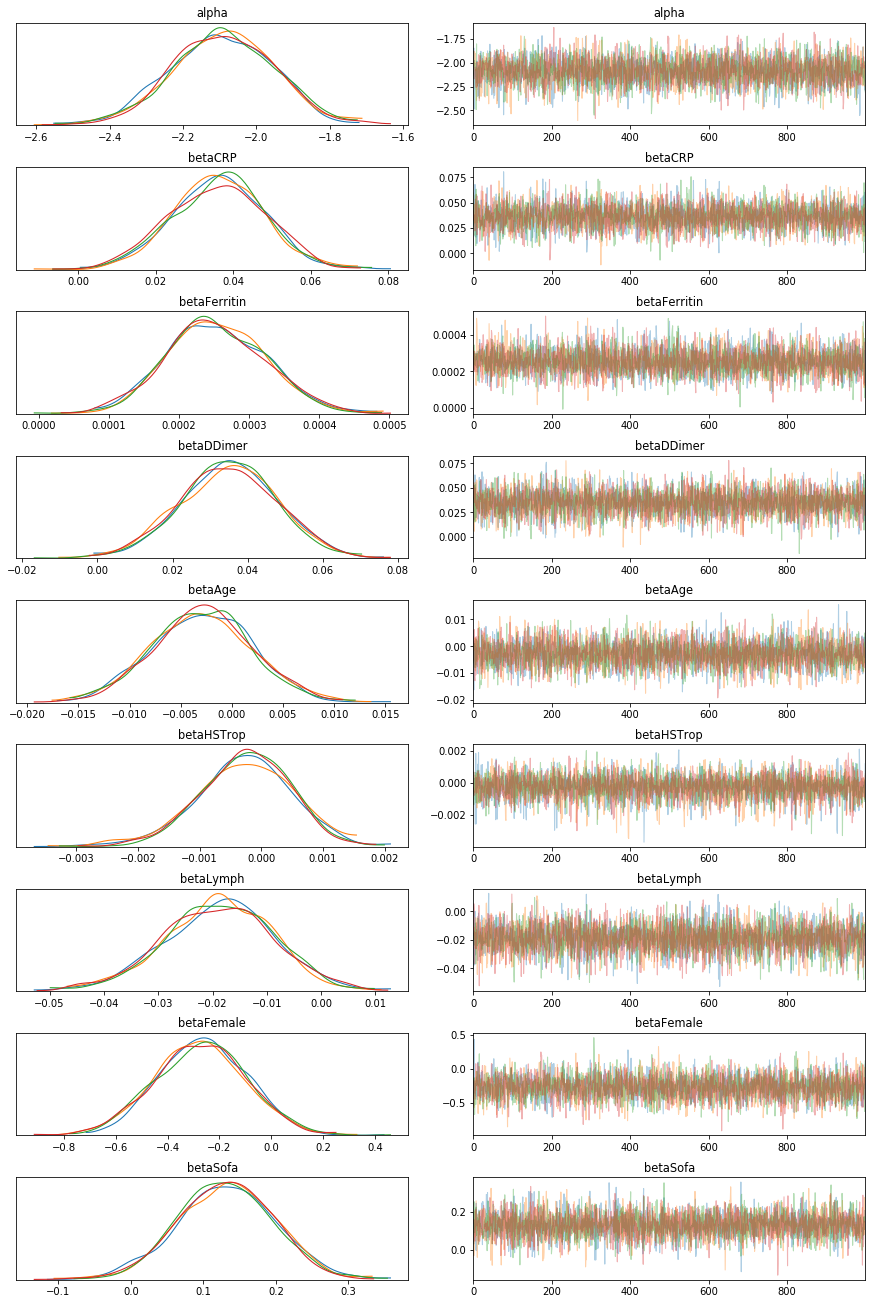

In [37]:
az.plot_trace(trace_logitICU, var_names=['alpha', 'betaCRP', 'betaFerritin', 'betaDDimer', 'betaAge', 'betaHSTrop',
                               'betaLymph', 'betaFemale', 'betaSofa'])

In [82]:
ppc = pm.sample_ppc(trace_logitICU, model=logitICUWIthPriors, samples=500)
probs = ppc['y_1'].mean(axis=0)

preds = np.rint(probs).astype('int')
print(f'Accuracy: {accuracy_score(icu, preds):.3f}')
print(f'f1 score: {f1_score(icu, preds):.3f}')
print(f'ROC: {roc_auc_score(icu, probs):.3f}')

/Users/burke/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  """Entry point for launching an IPython kernel.
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 500/500 [00:00<00:00, 1032.19it/s]

Accuracy: 0.885
f1 score: 0.143
ROC: 0.708


In [83]:
outputDF = pd.DataFrame({'predictedProb' : probs, 'icu' : icu})
outputDF['icuDecile'] = pd.qcut(outputDF.predictedProb, 10)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


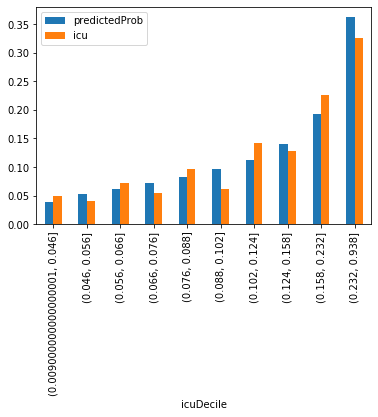

In [101]:
# calibration looks perfectly decent.
outputDF.groupby('icuDecile').mean().plot.bar()
plt.savefig('calibration.eps')

In [109]:
lymphs.mean()

NameError: name 'lymphs' is not defined

In [113]:
cleanedData.creatinine.describe()

count    1039.000000
mean        1.228859
std         1.699445
min         0.005000
25%         0.730000
50%         0.900000
75%         1.165000
max        34.120000
Name: creatinine, dtype: float64

In [127]:
test = az.summary(trace_logitICU, var_names=['alpha', 'betaCRP', 'betaFerritin', 'betaDDimer', 'betaAge', 'betaHSTrop',
                               'betaLymph', 'betaFemale', 'betaSofa'])[['mean', 'sd']]

In [129]:
test.to_stata('icuAdmitCoeffs-4-6-20.dta')

In [126]:
pd.cut([100], bins=[0, 100, 200, 300, 400, 1000]).codes[0]

0